## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [3]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Processing...
Done!


In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

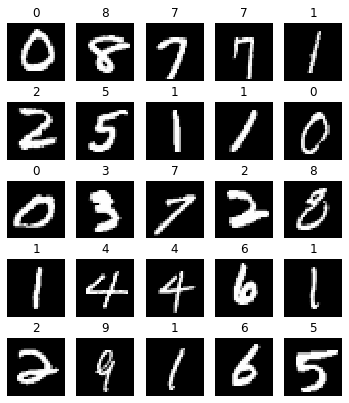

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [9]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [10]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.007164478302002
forward 1.1003587245941162
forward 0.6479977369308472
forward 0.49438202381134033
forward 0.4099849760532379
forward 0.3595050275325775
forward 0.3222925662994385
forward 0.2969549000263214
forward 0.2721771001815796
forward 0.255107045173645
backward 0.0030015010852366686
backward 0.0005810006405226886
backward 0.0005450858734548092
backward 0.0005019067320972681
backward 0.0004566303105093539
backward 0.0003984200593549758
backward 0.00033743432140909135
backward 0.0002654805139172822
backward 0.00017654101247899234
backward 0.0001764157204888761


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [11]:
def He_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0])
    weight.normal_(mean=0, std=np.sqrt(d))
    

init_f = He_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.007164478302002
forward 1.819019079208374
forward 1.4772473573684692
forward 1.4351874589920044
forward 1.4276068210601807
forward 1.451392650604248
forward 1.4174436330795288
forward 1.3641194105148315
forward 1.2098890542984009
forward 1.1937668323516846
backward 0.0030015010852366686
backward 0.003179267980158329
backward 0.003079376881942153
backward 0.0031028392259031534
backward 0.003073053900152445
backward 0.003084943164139986
backward 0.0030894826631993055
backward 0.0031769161578267813
backward 0.003104044822975993
backward 0.004391931463032961


<i> 1.4 Сделайте выводы по первой части </i>

Для He лучше всего подоходит функция активация ReLU, в то время как для Xavier - Tanh

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    #net.append(DropConnect(in_dim, out_dim))
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.599/0.294	Accuracy: 0.843/0.932


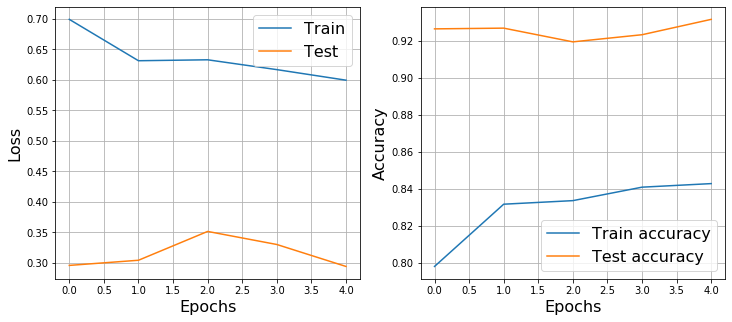

([0.699076141121545,
  0.6312930442885295,
  0.632832028527758,
  0.6167326698552317,
  0.5994347019363314],
 [0.296009204998801,
  0.30444739343999305,
  0.3516630551105813,
  0.33027523322195945,
  0.2943073972305165],
 [0.79824096, 0.83187854, 0.8338053, 0.84107924, 0.84300596],
 [0.92662185, 0.9270174, 0.9196005, 0.92345726, 0.93176425])

In [24]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda:0')

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Epoch 4... (Train/Test) NLL: 0.251/0.159	Accuracy: 0.932/0.958


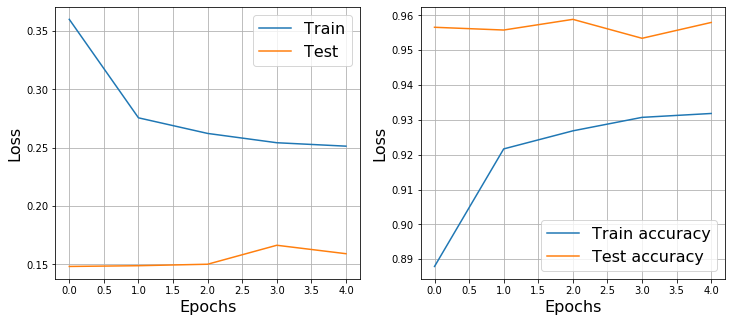

([0.36015503863091153,
  0.275709270271284,
  0.2623247703366569,
  0.25434841262474495,
  0.2514069686884057],
 [0.1482545633010472,
  0.1488834477112263,
  0.15015960135791875,
  0.16641749682117113,
  0.15918436255070229],
 [0.8879153, 0.921664, 0.92685014, 0.93072027, 0.93183637],
 [0.95658624, 0.9557951, 0.95886075, 0.95342165, 0.95797074])

In [29]:
train(net, train_loader, test_loader, 5, 0.01, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [14]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1).view(-1, 1)) / x.std(dim=1).view(-1, 1)
        print(output.shape)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [16]:
torch.cuda.is_available()

True

Epoch 9... (Train/Test) NLL: 0.014/0.069	Accuracy: 0.995/0.983


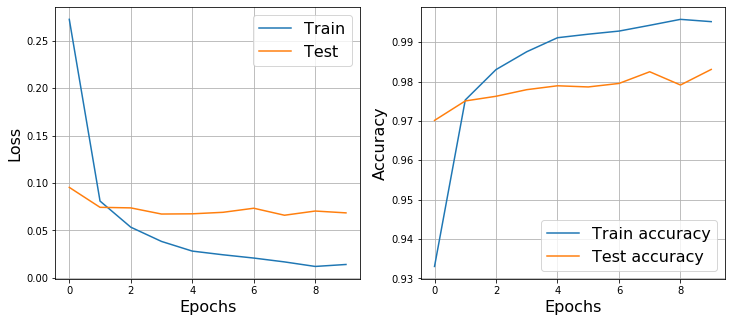

([0.27255685314504324,
  0.08095984213125668,
  0.05341599908059658,
  0.03838174579255998,
  0.028199788758844962,
  0.024310139492392413,
  0.020859473782069267,
  0.01679877331579672,
  0.01201187421593553,
  0.014089534984532196],
 [0.0954014399336486,
  0.07435432316947586,
  0.07376073527185223,
  0.0672759176526643,
  0.0675078837106688,
  0.06909934628188988,
  0.07339259965604619,
  0.06600880523837066,
  0.0704385669359678,
  0.06850275069569485],
 [0.9330135,
  0.9753243,
  0.9830479,
  0.98758996,
  0.9911492,
  0.9920487,
  0.99283713,
  0.99430305,
  0.9958189,
  0.99523586],
 [0.9701345,
  0.9750791,
  0.97626585,
  0.977947,
  0.9789359,
  0.97863925,
  0.97952926,
  0.982496,
  0.9791337,
  0.9830894])

In [17]:
# 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax()
                       )

train(network, train_loader, test_loader, 10, 0.001, ravel_init=True, device='cuda:3')

Epoch 9... (Train/Test) NLL: 0.018/0.087	Accuracy: 0.994/0.977


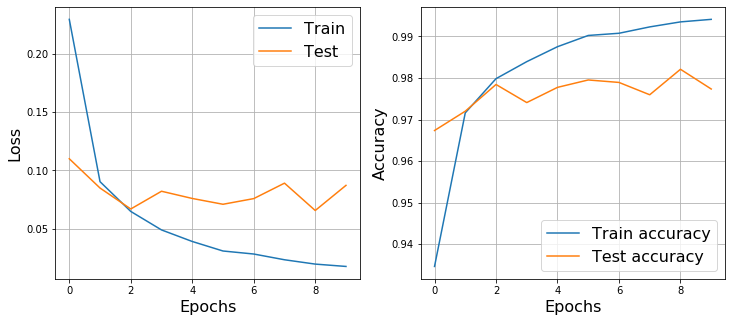

([0.2293426947616565,
  0.09028449862289911,
  0.06479947588670609,
  0.04895999777053338,
  0.039066575995799324,
  0.030913009765003916,
  0.028328534362635126,
  0.02340527438024468,
  0.019694374625021015,
  0.017683056562439972],
 [0.1099300248713433,
  0.08485035796331454,
  0.0669121760167653,
  0.08209695249701603,
  0.0759232809319149,
  0.07094123822790158,
  0.07580150053188016,
  0.0890248203532228,
  0.06561053954536401,
  0.08713373168124051],
 [0.93465704,
  0.97161514,
  0.97983855,
  0.98393637,
  0.98753446,
  0.99023855,
  0.99076605,
  0.9922986,
  0.99350345,
  0.9941143],
 [0.9673655,
  0.9720135,
  0.9784415,
  0.9740902,
  0.9777492,
  0.97952926,
  0.9789359,
  0.97596914,
  0.9821005,
  0.97735363])

In [21]:
# 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями
network = nn.Sequential(nn.Linear(784, 200),
                        nn.LayerNorm(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.LayerNorm(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 10, 0.001, ravel_init=True, device='cuda:3')

<i> 3.3 Сделайте выводы по третьей части </i>

<b>Layer normalization</b> дает чуть лучший результат. Вероятно, это происходит из-за того, что при работе с батчем сеть настраивается по среднему по разным объектам (в нашем случае разным изображением цифр), при <b>Layer normalization</b> этой проблемы нет. При этом видно, что она склонна к переобучению.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: